# Diabetes Analysis with Cross-Validation and Hyperparameter Tuning
This notebook demonstrates how to perform cross-validation and hyperparameter tuning on a diabetes dataset using scikit-learn. We use Decision Tree and Logistic Regression models, evaluate with stratified cross-validation, tune hyperparameters with GridSearchCV, and assess performance on a held-out test set with multiple metrics and ROC curves.

The code is organized into modular cells for clarity and robustness.

In [21]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    accuracy_score,
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
DEFAULT_DATA_PATH = '../data/diabetes_prediction_dataset.csv'


In [6]:
# Data handling
class PatientDataset:
    """
    Utility to load and preprocess a typical diabetes dataset.
    Assumes a binary target column named 'Outcome'.
    """
    def __init__(self, data_path: str = DEFAULT_DATA_PATH, random_state: int = RANDOM_STATE):
        self.path = data_path
        self.data = pd.read_csv(self.path)
        self.random_state = random_state

    def preprocess(self, target_col: str = 'Outcome'):
        """
        Basic, robust preprocessing suitable for tabular numeric data:
        - Drops duplicate rows
        - Splits into X (features) and y (target)
        - Returns X, y, and a ColumnTransformer that imputes numeric features
        """
        df = self.data.copy()
        # Basic cleanup
        df = df.drop_duplicates().reset_index(drop=True)
        if target_col not in df.columns:
            raise ValueError(f"Target column '{target_col}' not found in data. Columns: {list(df.columns)}")

        y = df[target_col].astype(int)
        X = df.drop(columns=[target_col])

        # Identify numeric columns (typical for diabetes dataset)
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        # Fallback if none detected
        if not num_cols:
            raise ValueError("No numeric feature columns found for preprocessing.")

        # Impute numerical features with median; scaling will be applied in specific pipelines
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_imputer', SimpleImputer(strategy='median'), num_cols)
            ],
            remainder='drop'
        )
        return X, y, preprocessor


Data shape: (100000, 9)

Dtypes:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Missing values per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Numeric summary (describe):
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000     

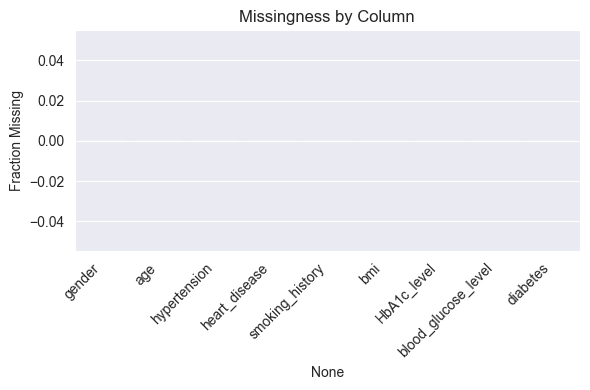

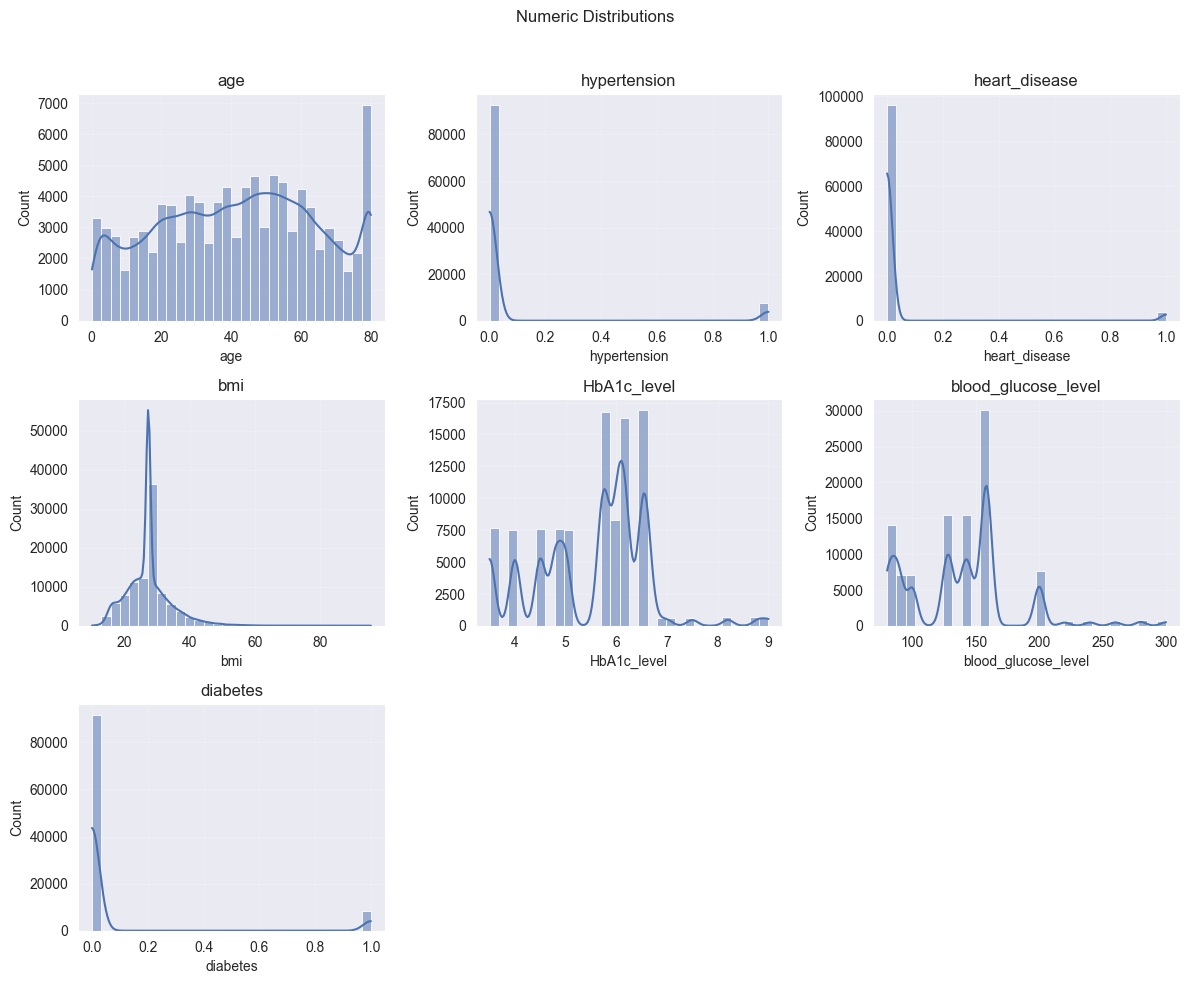

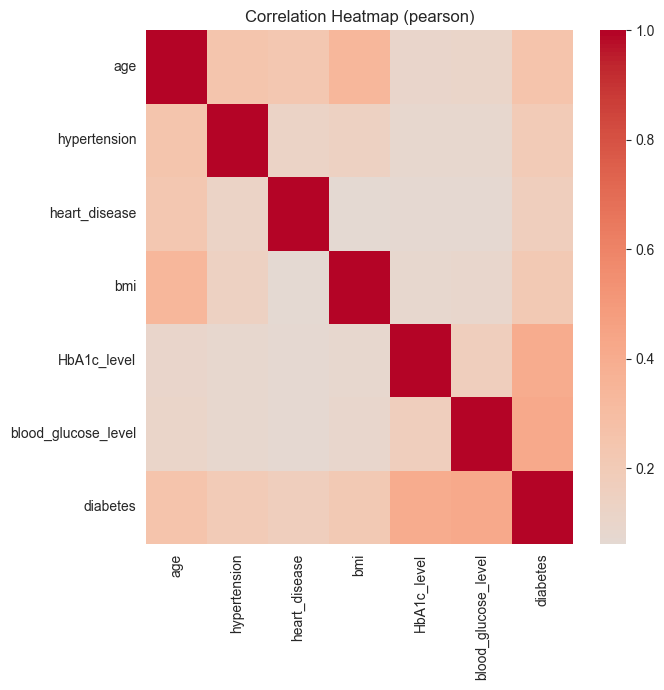

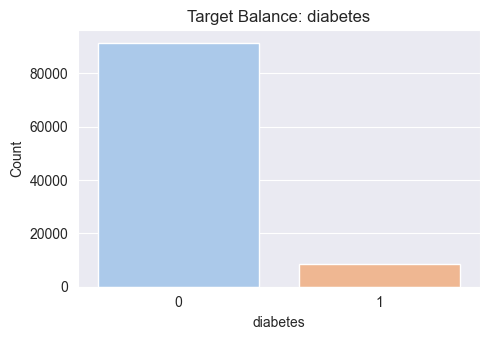

In [25]:
# Exploratory Data Analysis (EDA)
try:
    from eda import EDA
    # Quick EDA preview using the raw data (before train/test split)
    _ds_preview = PatientDataset(DEFAULT_DATA_PATH)
    _df_preview = _ds_preview.data.copy()
    _eda = EDA(_df_preview, target_col='diabetes')
    # Show overview and key visualizations
    _eda.quicklook()
except Exception as _eda_err:
    print('EDA skipped:', _eda_err)


In [9]:
# Model builders

def build_logreg_pipeline(preprocessor: ColumnTransformer, random_state: int = RANDOM_STATE):
    # Pipeline: Impute -> Scale -> Logistic Regression
    pipe = Pipeline(steps=[
        ('pre', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False safe for sparse outputs
        ('clf', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=random_state))
    ])

    # Grid: Only L2 penalty for solvers lbfgs/newton-cg/saga, and liblinear supports l2
    param_grid = {
        'clf__C': [0.01, 0.1, 1.0, 10.0],
        'clf__solver': ['liblinear', 'lbfgs']  # keep compatible with l2 by default
    }
    return pipe, param_grid


def build_tree_pipeline(preprocessor: ColumnTransformer, random_state: int = RANDOM_STATE):
    # Pipeline: Impute -> Decision Tree (no scaling necessary)
    pipe = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=random_state, class_weight='balanced'))
    ])

    param_grid = {
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [None, 3, 5, 7, 9, 12],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 5]
    }
    return pipe, param_grid


In [10]:
# Cross-validation utilities

def get_cv(n_splits: int = 5, random_state: int = RANDOM_STATE):
    return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)


def run_cross_validation(model, X, y, cv, scoring=None):
    if scoring is None:
        scoring = {
            'roc_auc': 'roc_auc',
            'accuracy': 'accuracy',
            'f1': 'f1'
        }
    return cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=False)



In [11]:
# Grid search utilities

def run_grid_search(pipeline, param_grid, X_train, y_train, cv, scoring='roc_auc'):
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train, y_train)
    return gs


In [12]:
# Evaluation utilities

def evaluate_on_test(model, X_test, y_test, model_name: str = "Model"):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        # Some models expose decision_function instead of predict_proba
        scores = model.decision_function(X_test)
        # Convert to [0,1] via min-max for AUC comparability (not probabilities)
        mn, mx = scores.min(), scores.max()
        y_proba = (scores - mn) / (mx - mn + 1e-12)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {model_name} | Test Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    if y_proba is not None:
        print(f"ROC AUC:  {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return {
        'accuracy': acc,
        'f1': f1,
        'roc_auc': auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }


def plot_roc_curves(models_with_names, X_test, y_test):
    plt.figure(figsize=(7, 6))
    for name, model in models_with_names:
        if hasattr(model, 'predict_proba'):
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
        elif hasattr(model, 'decision_function'):
            RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
        else:
            continue
    plt.title('ROC Curves')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [26]:
# Main workflow

def main(data_path: str = DEFAULT_DATA_PATH, target_col: str = 'diabetes'):
    # Load data
    print(f"Loading data from: {data_path}")
    ds = PatientDataset(data_path)
    X, y, preprocessor = ds.preprocess(target_col=target_col)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )

    # Build pipelines and parameter grids
    logreg_pipe, logreg_grid = build_logreg_pipeline(preprocessor)
    tree_pipe, tree_grid = build_tree_pipeline(preprocessor)

    # Cross-validation definition
    cv = get_cv(n_splits=5)

    # Optional: quick baseline CV without tuning
    print("\nRunning baseline cross-validation (no tuning)...")
    cv_scores_lr = run_cross_validation(logreg_pipe, X_train, y_train, cv)
    cv_scores_dt = run_cross_validation(tree_pipe, X_train, y_train, cv)
    print("LogReg CV (ROC AUC mean):", np.mean(cv_scores_lr['test_roc_auc']).round(4))
    print("Tree   CV (ROC AUC mean):", np.mean(cv_scores_dt['test_roc_auc']).round(4))

    # Grid search tuning
    print("\nRunning GridSearchCV for Logistic Regression (scoring=roc_auc)...")
    gs_lr = run_grid_search(logreg_pipe, logreg_grid, X_train, y_train, cv)
    print("Best LogReg params:", gs_lr.best_params_)
    print("Best LogReg CV ROC AUC:", round(gs_lr.best_score_, 4))

    print("\nRunning GridSearchCV for Decision Tree (scoring=roc_auc)...")
    gs_dt = run_grid_search(tree_pipe, tree_grid, X_train, y_train, cv)
    print("Best Tree params:", gs_dt.best_params_)
    print("Best Tree CV ROC AUC:", round(gs_dt.best_score_, 4))

    # Evaluate on test set
    results_lr = evaluate_on_test(gs_lr.best_estimator_, X_test, y_test, model_name='Logistic Regression (tuned)')
    results_dt = evaluate_on_test(gs_dt.best_estimator_, X_test, y_test, model_name='Decision Tree (tuned)')

    # Plot ROC curves
    plot_roc_curves([
        ('LogReg (tuned)', gs_lr.best_estimator_),
        ('Decision Tree (tuned)', gs_dt.best_estimator_)
    ], X_test, y_test)

    # Return a concise summary for downstream use if needed
    return {
        'best_params': {
            'logreg': gs_lr.best_params_,
            'tree': gs_dt.best_params_
        },
        'test_metrics': {
            'logreg': {k: v for k, v in results_lr.items() if k in ['accuracy', 'f1', 'roc_auc']},
            'tree': {k: v for k, v in results_dt.items() if k in ['accuracy', 'f1', 'roc_auc']}
        }
    }


Loading data from: ../data/diabetes_prediction_dataset.csv

Running baseline cross-validation (no tuning)...
LogReg CV (ROC AUC mean): 0.9615
Tree   CV (ROC AUC mean): 0.8521

Running GridSearchCV for Logistic Regression (scoring=roc_auc)...
Best LogReg params: {'clf__C': 0.01, 'clf__solver': 'lbfgs'}
Best LogReg CV ROC AUC: 0.9615

Running GridSearchCV for Decision Tree (scoring=roc_auc)...
Best Tree params: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best Tree CV ROC AUC: 0.9744

=== Logistic Regression (tuned) | Test Metrics ===
Accuracy: 0.8834
F1-score: 0.5692
ROC AUC:  0.9595

Classification Report:
               precision    recall  f1-score   support

           0     0.9864    0.8843    0.9325     17534
           1     0.4221    0.8738    0.5692      1696

    accuracy                         0.8834     19230
   macro avg     0.7042    0.8791    0.7509     19230
weighted avg     0.9366    0.8834    0.9005     19

<Figure size 700x600 with 0 Axes>

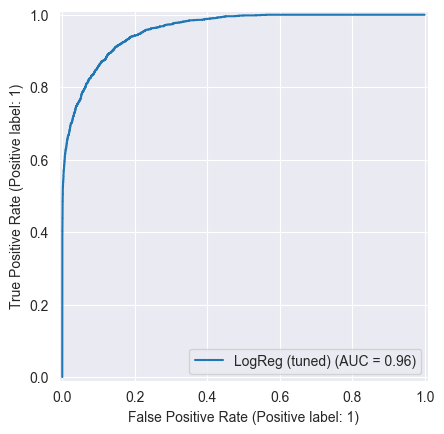

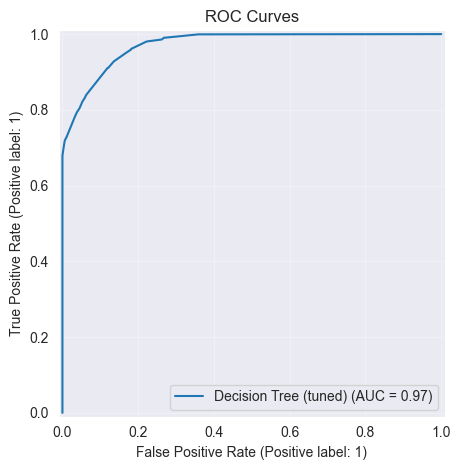


Summary: {'best_params': {'logreg': {'clf__C': 0.01, 'clf__solver': 'lbfgs'}, 'tree': {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}}, 'test_metrics': {'logreg': {'accuracy': 0.8833593343733749, 'f1': 0.5692337238333013, 'roc_auc': 0.9595135650197676}, 'tree': {'accuracy': 0.8820072802912117, 'f1': 0.5766001119611868, 'roc_auc': 0.9722602454584194}}}


In [27]:
# Entrypoint for script execution within the notebook environment
if __name__ == '__main__':
    data_path = DEFAULT_DATA_PATH if os.path.exists(DEFAULT_DATA_PATH) else DEFAULT_DATA_PATH
    try:
        summary = main(data_path=data_path)
        print("\nSummary:", summary)
    except Exception as e:
        print("Error during execution:", e)
